# Basic UMAP Usage and Parameters

UMAP is a fairly flexible non-linear dimension reduction algorithm. It seeks to learn the manifold structure of your data and find a low dimensional embedding that preserves the essential topological structure of that manifold. In this notebook we will generate some visualisable 4-dimensional data, demonstrate how to use UMAP to provide a 2-dimensional representation of it, and then look at how various UMAP parameters can impact the resulting embedding. This notebook is based on the work of Philippe Rivière for visionscarto.net.

In [1]:
!python --version

Python 3.7.4


To start we'll need some basic libraries. First ``numpy`` will be needed for basic array manipulation. Since we will be visualising the results we will need ``matplotlib`` and ``seaborn``. Finally we will need ``umap`` for doing the dimension reduction itself.

In [2]:
!pip install numpy matplotlib seaborn umap-learn

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import umap
%matplotlib inline
sns.set(style='white', rc={'figure.figsize':(12,8)})

Next we will need some data to embed into a lower dimensional representation. To make the 4-dimensional data "visualisable" we will generate data uniformly at random from a 4-dimensional cube such that we can interpret a sample as a tuple of (R,G,B,a) values specifying a color (and translucency). Thus when we plot low dimensional representations each point can colored according to its 4-dimensional value. For this we can use ``numpy``. We will fix a random seed for the sake of consistency.

In [2]:
np.random.seed(42)
data = np.random.rand(800, 4)

Now we need to find a low dimensional representation of the data. The ``umap`` library provides a ``UMAP`` class that is fully compatible with ``scikit-learn``. Thus, if you are familiar with ``scikit-learn`` the following will seem natural. For those no faimilar with the excellent ``scikit-learn`` library, the first step is to instantiate an object of the ``UMAP`` class (the hyperparameters for the model are set at this stage, as we will see shortly); that object then provides some standard methods, notably ``fit`` and ``fit_transform``. These methods take a dataset, and fit the model to the data. In the case of ``fit_transform`` the return value is the transformation of the data under the resulting fitting.

In [3]:
fit = umap.UMAP()
%time u = fit.fit_transform(data)

CPU times: user 10.8 s, sys: 243 ms, total: 11.1 s
Wall time: 6.1 s


The resulting value ``u`` is a 2-dimensional representation of the data. We can visualise the result by using ``matplotlib`` to draw a scatter plot of ``u``. We can color each point of the scatter plot by the associated 4-dimensional color from the source data.

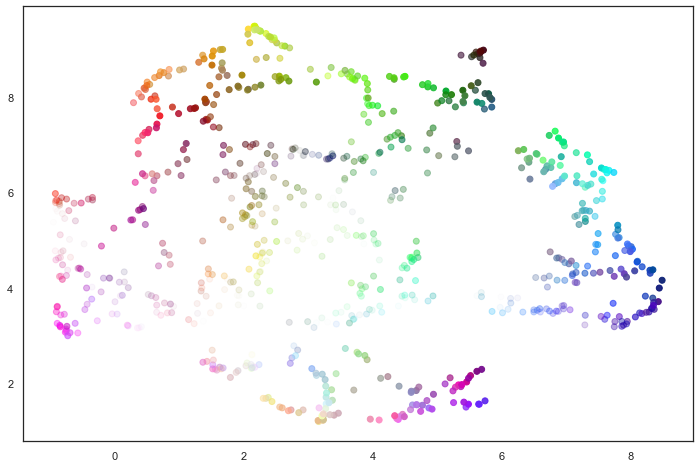

In [4]:
plt.scatter(u[:,0], u[:,1], c=data)

As you can see the result is that the data is placed in 2-dimensional space such that points that were nearby in in 4-dimensional space (i.e. are similar colors) are kept close together. Since we drew a random selection of points in the color sube there is a certain amount of induced structure from where the random points happened to clump up in color space.

## Parameter Selection

UMAP has several hyperparameters that can have a significant impact on the resulting embedding. In this notebook we will be covering the four major ones:

 - ``n_neighbors``
 - ``min_dist``
 - ``n_components``
 - ``metric``
 
Each of these parameters has a distinct effect, and we will look at each in turn. To make exploration simpler we will first write a short utility function that can fit the data with UMAP given a set of parameter choices, and plot the result.


In [5]:
def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data);
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), c=data)
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], c=data)
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], c=data)
    plt.title(title, fontsize=18)

### ``n_neighbors``

This parameter controls how UMAP balances local versus global structure in the data. It does this by constraining the size of the local neighborhood UMAP will look at when attempting to learn the manifold structure of the data. This means that low values of ``n_neighbors`` will force UMAP to concentrate on very local structure (potentially to the detriment of the big picture), while large values will push UMAP to look at larger neighborhoods of each point when estimating the manifold structure of the data, loosing fine detail structure for the sake of getting the broader of the data.

We can see that in practice by fitting our dataset with UMAP using a range of ``n_neighbors`` values. The default value of ``n_neighbors`` for UMAP (as used above) is 15, but we will look at values ranging from 2 (a very local view of the manifold) up to 200 (a quarter of the data).

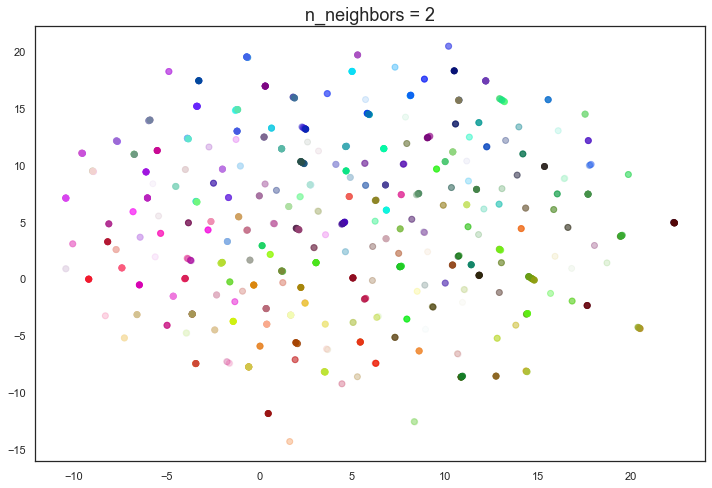

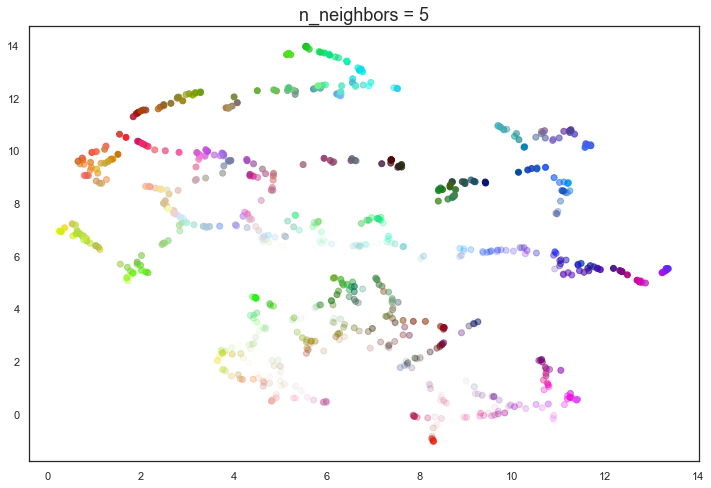

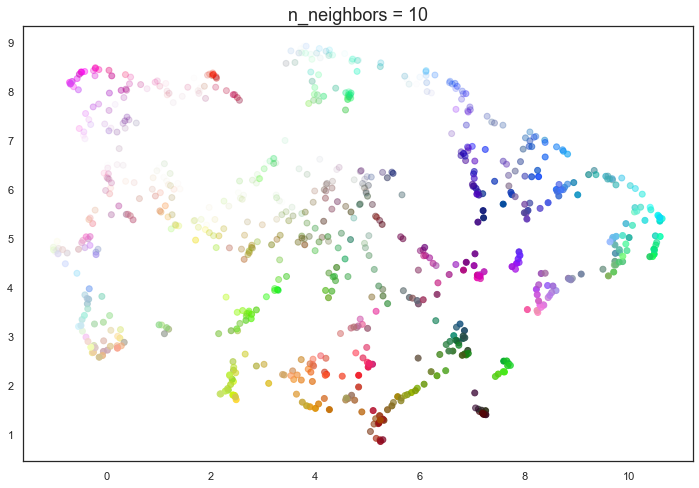

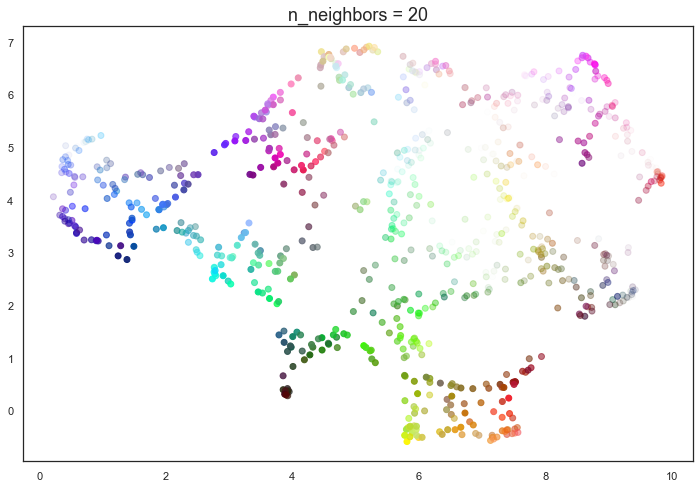

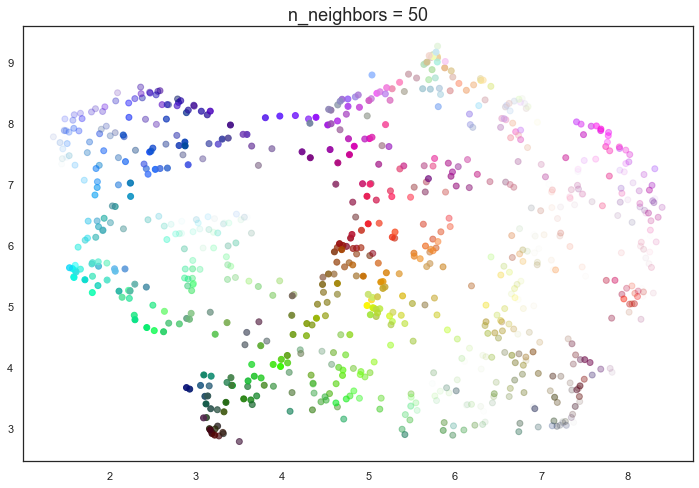

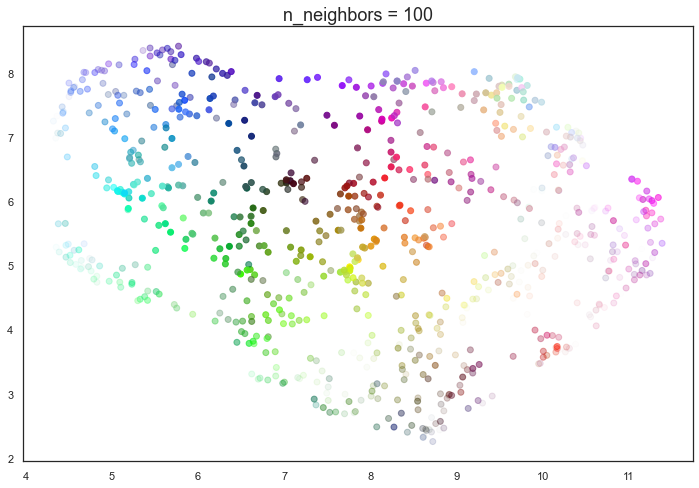

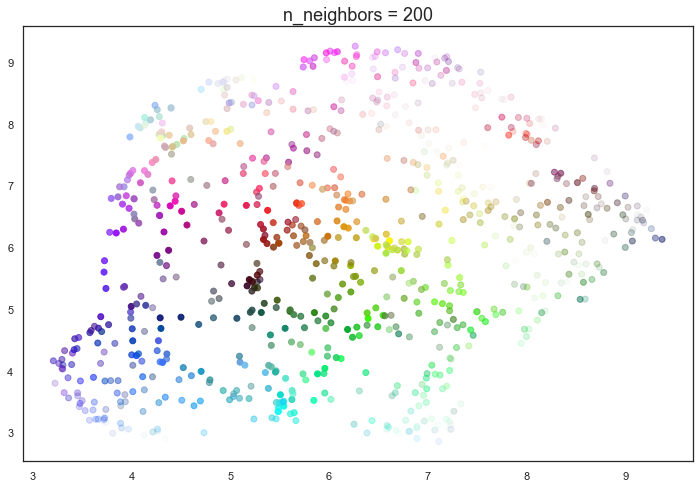

In [6]:
for n in (2, 5, 10, 20, 50, 100, 200):
    draw_umap(n_neighbors=n, title='n_neighbors = {}'.format(n))

With a value of ``n_neighbors=2`` we see that UMAP merely glues together small chains, but due to the narrow/local view, fails to see how those connect together. It also leaves many different components (and even singleton points). This represents the fact that from a fine detail point of view the data is very disconnected and scattered throughout the space.

As ``n_neighbors`` is increased UMAP manages to see more of the overall structure of the data, gluing more components together, and better coverying the broader structure of the data. By the stage of ``n_neighbors=20`` we have a fairly good overall view of the data showing how the various colors interelate to each other over the whole dataset.

As ``n_neighbors`` increases further more and more focus in placed on the overall structure of the data. This results in, with ``n_neighbors=200`` a plot where the overall structure (blues, greens, and reds; high luminance versus low) is well captured, but at the loss of some of the finer local sturcture (individual colors are no longer necessarily immediately near their closest color match).

This effect well exemplifies the local/global tradeoff provided by ``n_neighbors``.

### ``min_dist``

The ``min_dist`` parameter controls how tightly UMAP is allowed to pack points together. It, quite literally, provides the minimum distance apart that points are allowed to be in the low dimensional representation. This means that low values of ``min_dist`` will result in clumpier embeddings. This can be useful if you are interested in clustering, or in finer topological structure.  Larger values of ``min_dist`` will prevent UMAP from packing point together and will focus instead on the preservation of the broad topological structure instead.

The default value for ``min_dist`` (as used above) is 0.1. We will look at a range of values from 0.0 through to 0.99.

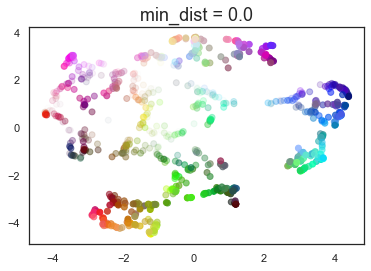

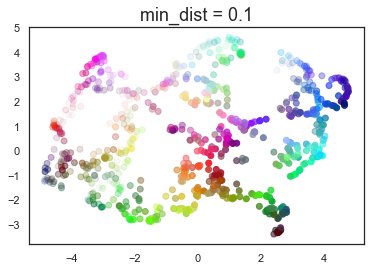

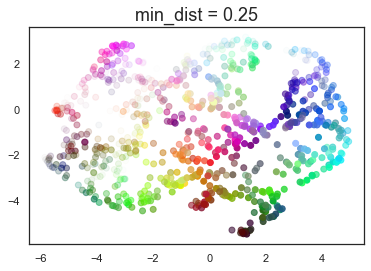

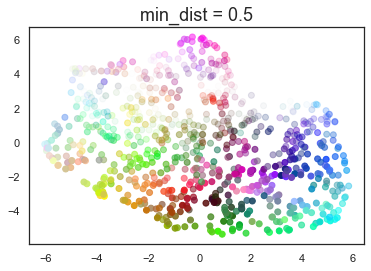

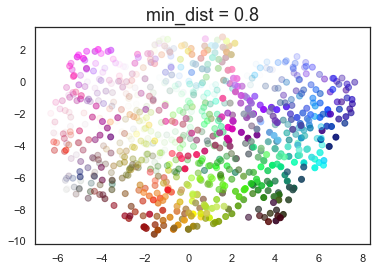

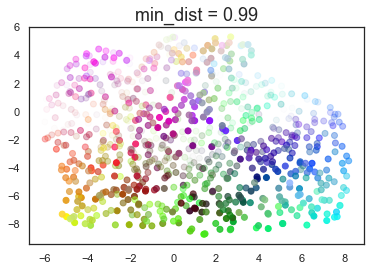

In [9]:
for d in (0.0, 0.1, 0.25, 0.5, 0.8, 0.99):
    draw_umap(min_dist=d, title='min_dist = {}'.format(d))

Here we see that with ``min_dist=0.0`` UMAP manages to find small connected components, clumps and strings in the data, and emphasises these features in the resulting embedding. As ``min_dist`` is increased these structures are pushed apart into softer more general features, providing a better overarching view of the data at the loss of the more detailed topological structure. 

### ``n_components``

As is standard for many ``scikit-learn`` dimension reduction algorithms UMAP provides a ``n_components`` parameter option that allows the user to determine the dimensionality of the reduced dimension space we will be embedding the data into. Unlike some other visualisation algorithms such as t-SNE UMAP scales well in embedding dimension, so you can use it for more than just visualisation in 2- or 3-dimensions.

For the purposes of this demonstration (so that we can see the effects of the parameter) we will only be looking at 1-dimensional and 3-dimensional embeddings, which we have some hope of visualizing.

First of all we will set ``n_components`` to 1, forcing UMAP to embed the data in a line. For visualisation purposes we will randomly distribute the data on the y-axis to provide some separation between points.

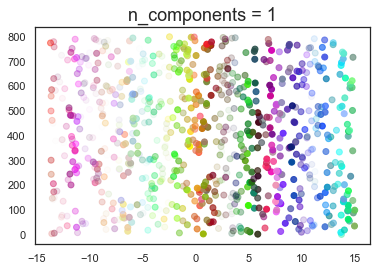

In [10]:
draw_umap(n_components=1, title='n_components = 1')

Now we will try ``n_components=3``. For visualisation we will make use of ``matplotlib``'s basic 3-dimensional plotting.

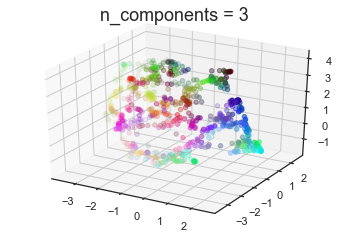

In [11]:
draw_umap(n_components=3, title='n_components = 3')

Here we can see that with more dimensions in which to work UMAP has an easier time separating out the colors in a way that respects the topological structure of the data.

As mentioned, there is really no requirement to stop at ``n_components`` at 3. If you are interested in (density based) clustering, or other machine learning techniques, it can be beneficial to pick a larger embedding dimension (say 10, or 50) closer to the the dimension of the underlying manifold on which your data lies.

### ``metric``

The final UMAP parameter we will be considering in this notebook is the ``metric`` parameter. This controls how distance is computed in the ambient space of the input data. By default UMAP supports a wide variety of metrics, including:

**Minkowski style metrics**
* euclidean
* manhattan
* chebyshev
* minkowski

**Miscellaneous spatial metrics**
* canberra
* braycurtis
* haversine

**Normalized spatial metrics**
* mahalanobis
* wminkowski
* seuclidean

**Angular and correlation metrics**
* cosine
* correlation

**Metrics for binary data**
* hamming
* jaccard
* dice
* russelrao
* kulsinski
* rogerstanimoto
* sokalmichener
* sokalsneath
* yule

Any of which can be specified by setting ``metric='<metric name>'``; for example to use cosine distance as the metric you would use ``metric='cosine'``.

UMAP offers more than this however -- it supports custom user defined metrics as long as those metrics can be compiled in ``nopython`` mode by numba. For this notebook we will be looking at such custom metrics. To define such metrics we'll need numba ...

In [7]:
import numba

For our first custom metric we'll define the distance to be the absolute value of difference in the red channel.

In [8]:
@numba.njit()
def red_channel_dist(a,b):
    return np.abs(a[0] - b[0])

To get more adventurous it will be useful to have some colorspace conversion -- to keep things simple we'll just use HSL formulas to extract the hue, saturation, and lightness from an (R,G,B) tuple.

In [9]:
@numba.njit()
def hue(r, g, b):
    cmax = max(r, g, b)
    cmin = min(r, g, b)
    delta = cmax - cmin
    if cmax == r:
        return ((g - b) / delta) % 6
    elif cmax == g:
        return ((b - r) / delta) + 2
    else:
        return ((r - g) / delta) + 4
    
@numba.njit()
def lightness(r, g, b):
    cmax = max(r, g, b)
    cmin = min(r, g, b)
    return (cmax + cmin) / 2.0

@numba.njit()
def saturation(r, g, b):
    cmax = max(r, g, b)
    cmin = min(r, g, b)
    chroma = cmax - cmin
    light = lightness(r, g, b)
    if light == 1:
        return 0
    else:
        return chroma / (1 - abs(2*light - 1))

With that in hand we can define three extra distances. The first simply measures the difference in hue, the second measures the euclidean distance in a combined saturation and lightness space, while the third measures distance in the full HSL space.

In [10]:
@numba.njit()
def hue_dist(a, b):
    diff = (hue(a[0], a[1], a[2]) - hue(b[0], b[1], b[2])) % 6
    if diff < 0:
        return diff + 6
    else:
        return diff

@numba.njit()
def sl_dist(a, b):
    a_sat = saturation(a[0], a[1], a[2])
    b_sat = saturation(b[0], b[1], b[2])
    a_light = lightness(a[0], a[1], a[2])
    b_light = lightness(b[0], b[1], b[2])
    return (a_sat - b_sat)**2 + (a_light - b_light)**2

@numba.njit()
def hsl_dist(a, b):
    a_sat = saturation(a[0], a[1], a[2])
    b_sat = saturation(b[0], b[1], b[2])
    a_light = lightness(a[0], a[1], a[2])
    b_light = lightness(b[0], b[1], b[2])
    a_hue = hue(a[0], a[1], a[2])
    b_hue = hue(b[0], b[1], b[2])
    return (a_sat - b_sat)**2 + (a_light - b_light)**2 + (((a_hue - b_hue) % 6) / 6.0)

With such custom metrics in hand we can get UMAP to embed the data using those metrics to measure distance between our input data points. Note that ``numba`` provides significant flexibility in what we can do in defining distance functions. Despite this we retain the high performance we expect from UMAP even using such custom functions.

/opt/anaconda3/envs/umap/lib/python3.6/site-packages/umap/umap_.py:1496: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  "custom distance metric does not return gradient; inverse_transform will be unavailable. "
/opt/anaconda3/envs/umap/lib/python3.6/site-packages/umap/umap_.py:1496: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  "custom distance metric does not return gradient; inverse_transform will be unavailable. "
/opt/anaconda3/envs/umap/lib/python3.6/site-packages/umap/umap_.py:1496: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable us

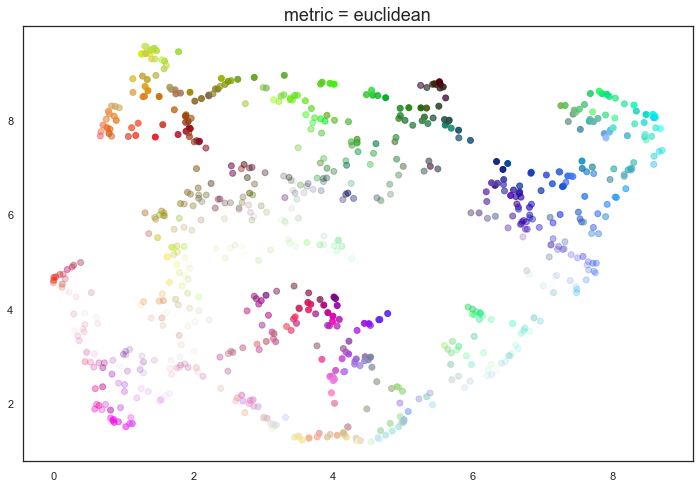

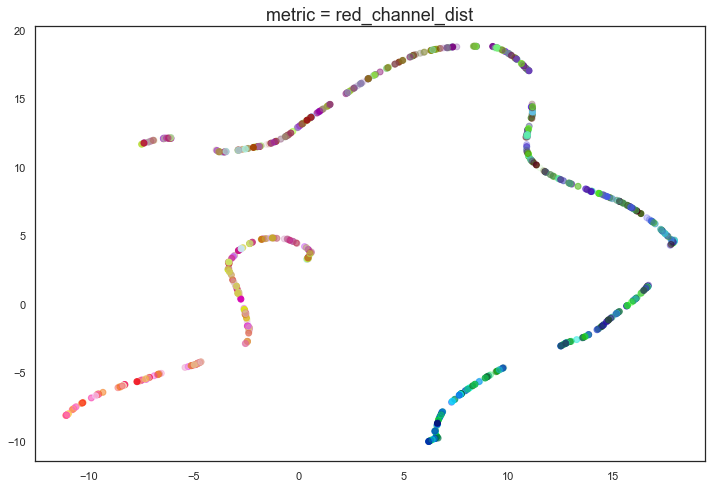

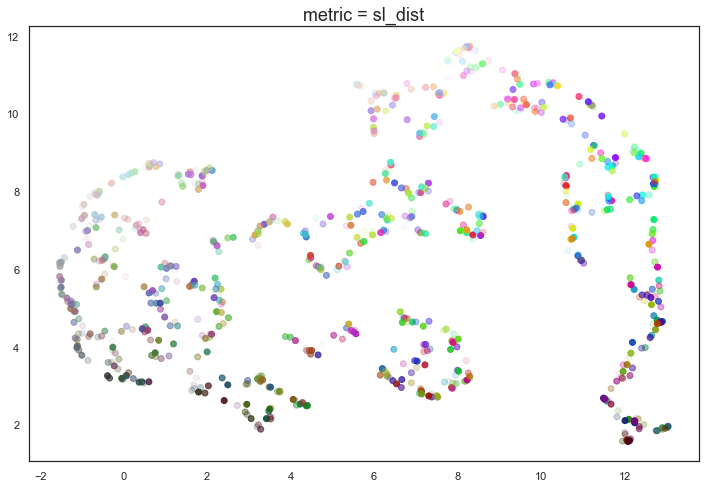

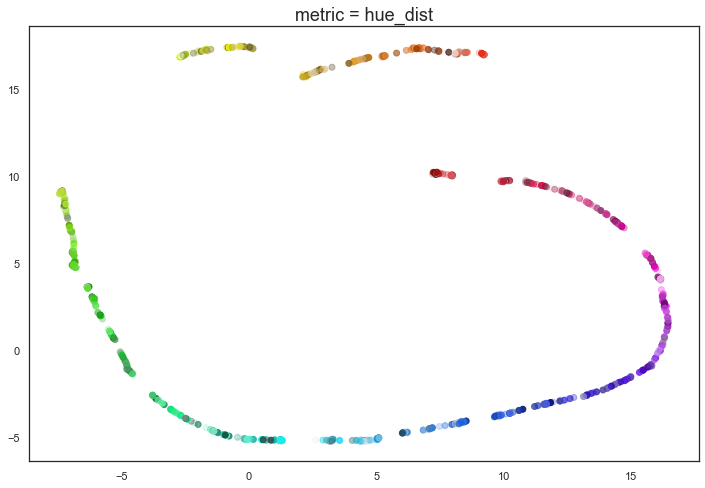

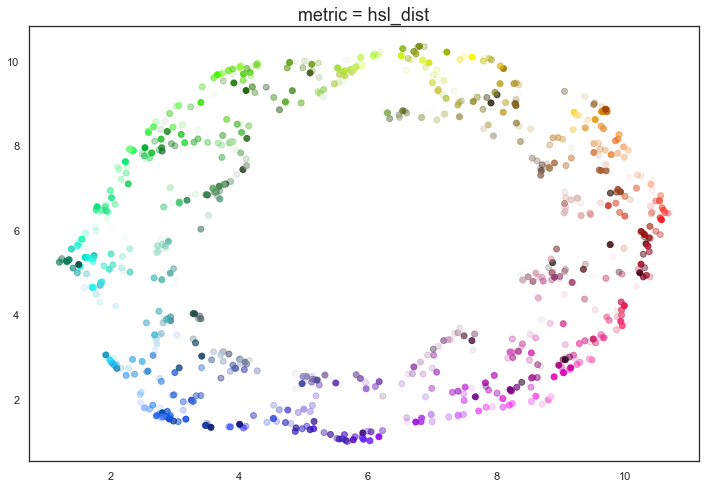

In [11]:
for m in ("euclidean", red_channel_dist, sl_dist, hue_dist, hsl_dist):
    name = m if type(m) is str else m.__name__
    draw_umap(n_components=2, metric=m, title='metric = {}'.format(name))

And here we can see the effects of the metrics quite clearly. The pure red channel correctly see the data as living on a one dimensional manifold, the hue metric interprets the data as living in a circle, and the HSL metric fattens out the circle according to the saturation and lightness. This provides a reasonable demonstration of the power and flexibility of UMAP in understanding the underlying topology of data, and finding a suitable low dimensional representation of that topology.